# 1.Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras import regularizers

In [2]:
from sklearn.model_selection import train_test_split

In [3]:

XL=pd.read_csv('9_510_L_resample_95_5.csv')
XU_train=pd.read_csv('9_510_U_resample_95_5.csv')# No resampling done in the unlabeled set, It just denotes the pair of L and U


In [4]:
from sklearn.utils import shuffle
XU_train.head()

,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Fwd.Packet.Length.Max,...,act_data_pkt_fwd,min_seg_size_forward,Active.Mean,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min
0,180881158,3128,3232288105,3125,6,1.494314e+09,182,2,0,55,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,180881370,47719,3003188475,443,6,1.494314e+09,16259595,21,12,258,...,4,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3232238139,55664,180881160,3128,6,1.494314e+09,13470045,15,25,258,...,13,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3232258715,2310,180881161,3128,6,1.494314e+09,258099,6,36,1460,...,5,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,180881156,3128,3232243811,50141,6,1.494314e+09,73512428,4,2,257,...,3,20,4453.0,0.0,4453.0,4453.0,73504132.0,0.0,73504132.0,73504132.0


In [5]:
XL.head()

,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Fwd.Packet.Length.Max,...,min_seg_size_forward,Active.Mean,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,ProtocolName
0,180881370,44176,872483344,80,6,1.494318e+09,263343,9,8,1,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AMAZON
1,180881351,58339,877954422,80,6,1.494314e+09,59769277,9,6,712,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AMAZON
2,919780279,443,180881348,55558,6,1.494324e+09,130702,3,3,542,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AMAZON
3,180881351,55012,839964609,80,6,1.494322e+09,188648,3,5,92,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AMAZON
4,877262549,443,180881369,50404,6,1.494314e+09,1984,4,3,681,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AMAZON


In [6]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 

Using TensorFlow backend.


In [7]:
a=XL.groupby('ProtocolName')['ProtocolName'].count().sort_values(ascending=False)


In [8]:
a   # see resampled instances

ProtocolName
GOOGLE            5365
YOUTUBE           5000
YAHOO             5000
APPLE             5000
APPLE_ITUNES      5000
CLOUDFLARE        5000
CONTENT_FLASH     5000
DROPBOX           5000
EBAY              5000
FACEBOOK          5000
GMAIL             5000
HTTP              5000
HTTP_CONNECT      5000
HTTP_PROXY        5000
MICROSOFT         5000
MSN               5000
OFFICE_365        5000
SKYPE             5000
SSL               5000
TWITTER           5000
WHATSAPP          5000
WIKIPEDIA         5000
WINDOWS_UPDATE    5000
AMAZON            5000
Name: ProtocolName, dtype: int64

In [9]:
'''
Function mask_noise

Input: numpy array , fraction_delete(between 0 and 1)

Removes a fraction_delete fraction of the input array X randomly

Output: numpy array after deletions

'''
def mask_noise(X,fraction_delete=0.2):
    mask=np.random.rand(np.shape(X)[0],np.shape(X)[1])
    mask=1*(mask>fraction_delete)
    return mask*X

In [10]:
'''
Function Gaussian_noise

Input: numpy array , sigma

adds noise distributed normally with a stddev sigma 

Output: numpy array after adding noise

'''
def Gaussian_noise(X,sigma=0.5):
    noise = np.random.normal(0,sigma,np.shape(X))
    return noise+X

In [11]:
from keras.layers import Input, Dense
from keras.models import Model
import keras.backend as K
import tensorflow as tf
from tensorflow.keras import regularizers
from keras.models import load_model
import keras
from keras.layers import Dropout

In [12]:
'''
Sparcity Autoencoder's Sparcity Activity Regularization

'''
def kl_divergence(rho, rho_hat):
    return rho * tf.math.log(rho) - rho * tf.math.log(rho_hat+1e-12) + (1 - rho) * tf.math.log(1 - rho) - (1 - rho) * tf.math.log(1 - rho_hat+1e-12)

class SparseActivityRegularizer(tf.keras.regularizers.Regularizer):

    def __init__(self, p=0.1, sparsityBeta=3):
        self.p = p
        self.sparsityBeta = sparsityBeta

    def __call__(self, x):
        regularization = 0            

        p_hat = K.mean(x, axis=0)
        regularization += self.sparsityBeta * K.sum(kl_divergence(self.p, p_hat))

        return regularization

    def get_config(self):
        return {"name": self.__class__.__name__} 

In [13]:
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder

In [14]:
yL_train=XL.iloc[:,-1]
XL_train=XL.iloc[:,:-1]

In [15]:
yL_train=pd.get_dummies(yL_train)#One-hot_encoding

# Split into train,test and val

#randomly split into train(80%) and val(20%)
XL_train,XL_val,yL_train,yL_val=train_test_split(XL_train,yL_train,random_state=0,test_size=0.2)

#randomly split val into val(10%) and test(10%)
XL_val,XL_test,yL_val,yL_test=train_test_split(XL_val,yL_val,random_state=0,test_size=0.5)

 Reversing the one hot encoding for each set to be used for ML methods

In [16]:
yL_train2=yL_train[yL_train==1].stack().reset_index().drop(0,1)['level_1'] # reversing the one hot encoding for each set

In [17]:
yL_val2=yL_val[yL_val==1].stack().reset_index().drop(0,1)['level_1']# reversing the one hot encoding for each set

In [18]:
yL_test2=yL_test[yL_test==1].stack().reset_index().drop(0,1)['level_1']# reversing the one hot encoding for each set

In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

#scaling and normalization
scaler=StandardScaler()
XU_train=scaler.fit_transform(XU_train)
XL_train=scaler.fit_transform(XL_train)
XL_val=scaler.transform(XL_val)
XL_test=scaler.transform(XL_test)


# 2. Training the SDAE
#### Training the Encoder parts

In [20]:
from keras_sequential_ascii import keras2ascii
from tensorflow.keras import regularizers
from keras.models import Sequential

In [21]:
from keras import backend as K


In [22]:
'''
Function SDAE
Inputs: numpy array X, list layers,list activations,float rho,int n_epochs,string denoise,float fraction_delete

denoise is the mode of adding noise
rho is the sparcity constraint parameter
layers is a list of no. of hidden nodes in each hidden layer
activations is a list of activations used in each encoding layer

trains each autoencoder layer and outputs all the encoder-layer models.

Output: a list of keras models

'''
def SDAE(X,layers,activations,rho,n_epochs,denoise,fraction_delete=0.2):
    layers.insert(0,len(X[0]))
    #layers.insert(0,len(X_train.iloc[0]))
    ec=[]
    for i in range(len(layers)-1):
        encoding_dim = layers[i+1]

    # this is our input placeholder
        input_ = Input(shape=(layers[i],))
    # define regulariser
        if rho[i] != None: 
            regulariser = SparseActivityRegularizer(rho[i],3)
        else:
            regulariser=None

        # "encoded" is the encoded representation of the input
        encoded = Dense(encoding_dim, activation=activations[i],bias_initializer='random_normal',kernel_initializer='he_uniform',activity_regularizer=regulariser,name='encoder'+str(i+1))(input_)
        
        # "decoded" is the lossy reconstruction of the input
        decoded = Dense(layers[i],activation=None,name='decoder'+str(i+1))(encoded)

        # this model maps an input to its reconstruction
        autoencoder = Model(input_, decoded)

        # this model maps an input to its encoded representation
        encoder = Model(input_, encoded)

        # create a placeholder for an encoded (32-dimensional) input
        encoded_input = Input(shape=(encoding_dim,))

        autoencoder.compile(optimizer=RMSprop(learning_rate=0.001,clipnorm=0.1), loss='mse')
        
        if denoise =='Gauss':
            X_noisy=Gaussian_noise(X,fraction_delete)
        else:
            X_noisy=mask_noise(X,fraction_delete)
        
        print('Training Layer ' + str(i+1)+' : ')
        autoencoder.fit(X_noisy,X,
                epochs=n_epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(X,X))
        ec.append(encoder)
        X=encoder.predict(X)
    print('All Layers Done!')    
    return ec       

In [23]:
#Train Sparse Stacked Denoising Autoencoder
layers = [100,200,400,50]
activations=['relu','relu','relu','relu']
rho=[0.06,0.06,0.06,0.06]
traint0=time.time()
stacked_layers=SDAE(XU_train,layers,activations,rho,10,'mask',0.02)

Training Layer 1 : 
Train on 384366 samples, validate on 384366 samples
Epoch 1/10
384366/384366 [==============================] - 8s 20us/step - loss: 3.2923 - val_loss: 0.4568
Epoch 2/10
384366/384366 [==============================] - 8s 20us/step - loss: 0.4191 - val_loss: 0.3589
Epoch 3/10
384366/384366 [==============================] - 8s 21us/step - loss: 0.3510 - val_loss: 0.3089
Epoch 4/10
384366/384366 [==============================] - 8s 20us/step - loss: 0.3105 - val_loss: 0.2697
Epoch 5/10
384366/384366 [==============================] - 7s 19us/step - loss: 0.2822 - val_loss: 0.2536
Epoch 6/10
384366/384366 [==============================] - 8s 20us/step - loss: 0.2568 - val_loss: 0.2220
Epoch 7/10
384366/384366 [==============================] - 8s 20us/step - loss: 0.2377 - val_loss: 0.2188
Epoch 8/10
384366/384366 [==============================] - 8s 21us/step - loss: 0.2207 - val_loss: 0.2071
Epoch 9/10
384366/384366 [==============================] - 8s 20us/step

# 3.Training the SoftMax classifier

In [24]:
'''
Performs a Forward Pass through the SDAE

'''
def SDAE_predict(stacked_layers,X):
    for layer in stacked_layers:
        X1=layer.predict(X)
        X=X1
    return X1    

In [25]:
#forward pass through SDAE
XL_train1=SDAE_predict(stacked_layers,XL_train)
XL_val1=SDAE_predict(stacked_layers,XL_val)
XL_test1=SDAE_predict(stacked_layers,XL_test)

### Please skip this section to part 6 If only ML methods are to be tested, The following is the DL NN model

In [27]:
#Train Classifier separately
input1 = Input(shape=(layers[-1],))
L1 = Dense(len(yL_train.columns),activation='softmax')(input1)
classifier=Model(input1,L1)   
classifier.compile(optimizer=SGD(learning_rate=0.1,momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])

In [28]:
history=classifier.fit(XL_train1,yL_train,
                epochs=50,
                #batch_size=256, #default batch_size=32
                shuffle=True,
                validation_data=(XL_val1, yL_val))

Train on 96292 samples, validate on 12036 samples
Epoch 1/50
96292/96292 [==============================] - 3s 26us/step - loss: 2.8137 - accuracy: 0.1870 - val_loss: 2.7148 - val_accuracy: 0.2038
Epoch 2/50
96292/96292 [==============================] - 2s 24us/step - loss: 2.6614 - accuracy: 0.2234 - val_loss: 2.6311 - val_accuracy: 0.2192
Epoch 3/50
96292/96292 [==============================] - 2s 24us/step - loss: 2.5980 - accuracy: 0.2376 - val_loss: 2.5866 - val_accuracy: 0.2342
Epoch 4/50
96292/96292 [==============================] - 2s 22us/step - loss: 2.5548 - accuracy: 0.2509 - val_loss: 2.5490 - val_accuracy: 0.2454
Epoch 5/50
96292/96292 [==============================] - 2s 22us/step - loss: 2.5232 - accuracy: 0.2604 - val_loss: 2.5201 - val_accuracy: 0.2492
Epoch 6/50
96292/96292 [==============================] - 2s 22us/step - loss: 2.4975 - accuracy: 0.2698 - val_loss: 2.5058 - val_accuracy: 0.2663
Epoch 7/50
96292/96292 [==============================] - 2s 22us/st

# 4. Fine Tuning
#### Fine Tuning Involves removing the sparsity regularizer from all the layers , adding dropout etc and performing backpropagation to improve the overall model accuracy 

In [29]:
# change regularisation settings
a=[]
for i in range(len(stacked_layers)):
    encoder=stacked_layers[i]
    #encoder.layers[-2].activity_regularizer=None  
    encoder.layers[-1].activity_regularizer=None #remove Sparse activity regularizer
    encoder.save('temp.h5')
    encoder=load_model('temp.h5')
    print(encoder.losses)
    a.append(encoder)
    
classifier.save('temp.h5')
classifier=load_model('temp.h5')
print(classifier.losses)
a.append(classifier)    

c:\users\dhruvjyoti\appdata\local\programs\python\python37\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[]
[]
[]
[]
[]


In [30]:
# add dropout till n-2 layers
model=Sequential()
for i in a:
    model.add(i)
    if i != classifier and i != encoder:
        model.add(Dropout(0.02))

In [31]:
model.save('temp.h5')
model=load_model('temp.h5')

c:\users\dhruvjyoti\appdata\local\programs\python\python37\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [32]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [35]:
#fine tune model runs for no. of epochs set below
history=model.fit(XL_train,yL_train,
                epochs=750,
                batch_size=256,
                shuffle=True,
                validation_data=(XL_val, yL_val),
                verbose=0)
traint1=time.time()

In [38]:
print("Train_time: "+str(traint1-traint0))

Train_time: 2712.742925100327


In [40]:
test0=time.time()
print(model.evaluate(XL_test,yL_test))
test1=time.time()
print("Test_time: "+str(test1-test0))

[0.2525774887911904, 0.951129241943359]
Test_time: 0.374902311706543


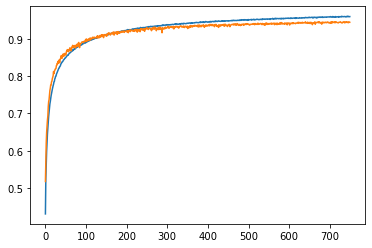

In [41]:
#Visualise convergence with no. of epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])


# 5. Results
#### Below are the results obtained on our NN model

In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [43]:
y_pred=model.predict(XL_test)

In [44]:
y_pred1=y_pred.argmax(axis=1)
y_pred1=np.append(y_pred1,np.arange(24))
y_pred1=pd.get_dummies(y_pred1,columns=yL_train.columns)
y_pred1.columns=yL_test.columns
y_pred1=y_pred1.iloc[:-24]

In [45]:
yL_test.sum()

AMAZON            500
APPLE             474
APPLE_ITUNES      515
CLOUDFLARE        461
CONTENT_FLASH     494
DROPBOX           487
EBAY              508
FACEBOOK          473
GMAIL             501
GOOGLE            550
HTTP              491
HTTP_CONNECT      490
HTTP_PROXY        533
MICROSOFT         497
MSN               497
OFFICE_365        522
SKYPE             491
SSL               517
TWITTER           509
WHATSAPP          506
WIKIPEDIA         511
WINDOWS_UPDATE    502
YAHOO             515
YOUTUBE           493
dtype: int64

In [46]:
y_test1 = yL_test.columns[np.where(yL_test!=0)[1]]

In [47]:
y_pred1=y_pred1.columns[np.where(y_pred1!=0)[1]]
y_pred1

Index(['WINDOWS_UPDATE', 'APPLE', 'APPLE_ITUNES', 'OFFICE_365', 'MICROSOFT',
       'WIKIPEDIA', 'CLOUDFLARE', 'HTTP_CONNECT', 'EBAY', 'MSN',
       ...
       'WINDOWS_UPDATE', 'YAHOO', 'HTTP_PROXY', 'GMAIL', 'HTTP', 'MSN',
       'GMAIL', 'HTTP_CONNECT', 'WHATSAPP', 'SKYPE'],
      dtype='object', length=12037)

In [48]:
cm=confusion_matrix(y_test1,y_pred1,labels=yL_test.columns)

In [49]:
cm_pc=pd.DataFrame((cm.T/np.sum(cm,axis=1)).T,columns=yL_test.columns,index=yL_test.columns)
cm_pc=cm_pc.replace(np.nan,0)


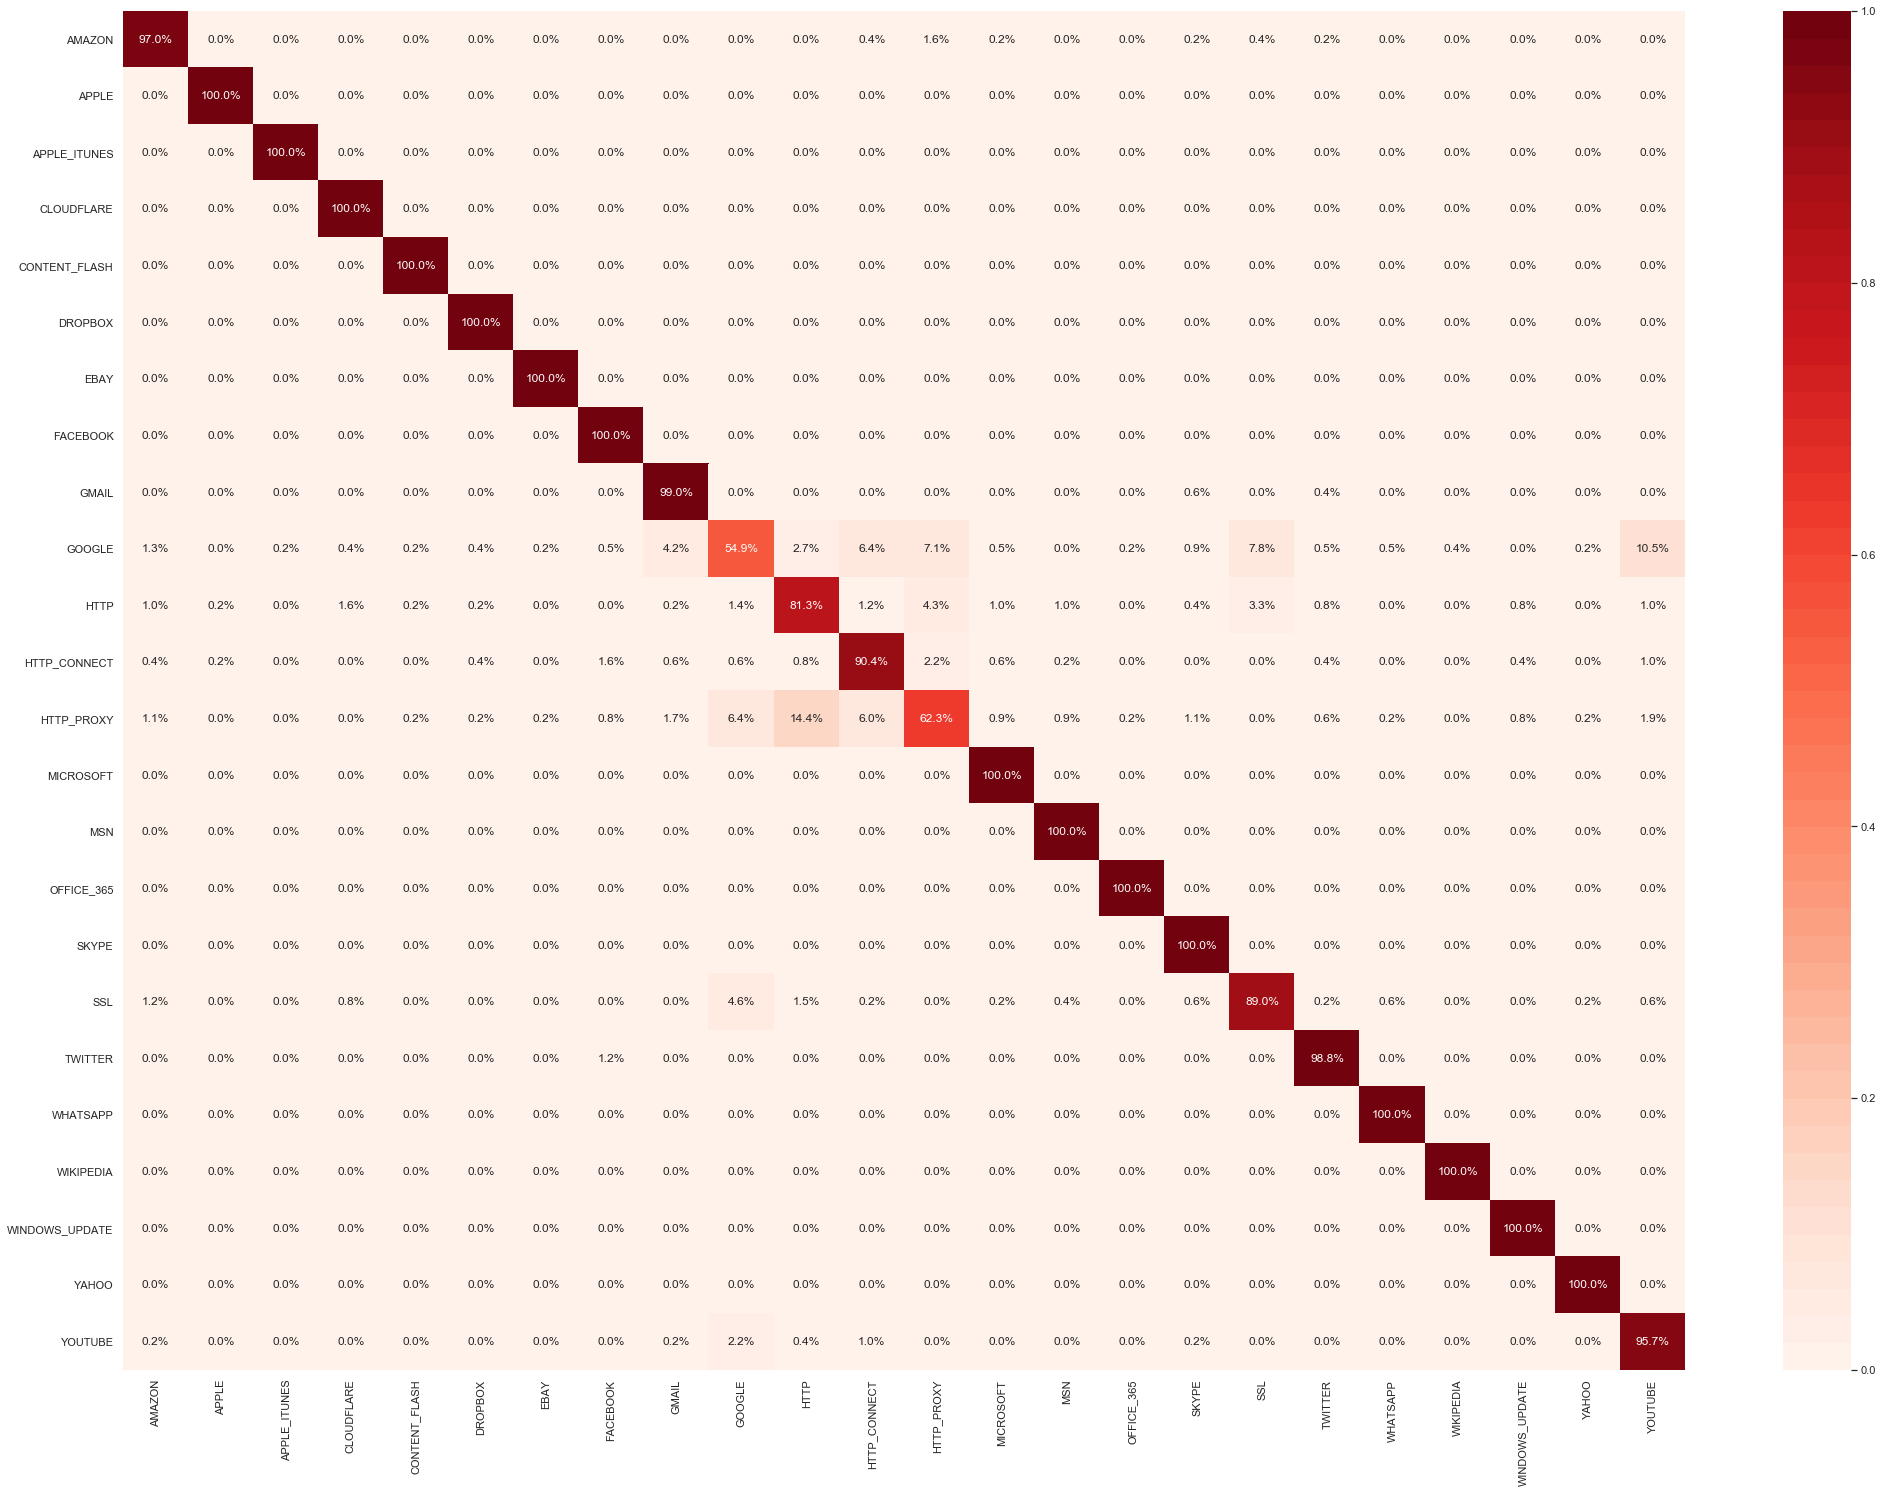

In [50]:
# Plot confusion matrix
plt.figure(figsize=(35,25))
df_cm=pd.DataFrame(cm,columns=yL_test.columns,index=yL_test.columns)
sns.set(font_scale=1.0)
sns.heatmap(cm_pc, annot=True,fmt='.1%',cmap=sns.color_palette("Reds",50)) # font size
plt.show()

In [51]:
print('Test Accuracy : '+str(accuracy_score(y_test1, y_pred1)))

Test Accuracy : 0.9503459582952563


In [52]:
print('weighted F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'weighted')))
print('Macro F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'macro')))
print('Micro F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'micro')))
print('F1 Scores : ' )
pd.DataFrame(f1_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['F1-score'],index=yL_test.columns)

weighted F1 Score : 0.9551652225407365
Macro F1 Score : 0.9440849230700469
Micro F1 Score : 0.9513459582952563
F1 Scores : 


,F1-score
AMAZON,0.958498
APPLE,0.997895
APPLE_ITUNES,0.999030
CLOUDFLARE,0.985043
CONTENT_FLASH,0.996973
DROPBOX,0.993878
EBAY,0.998035
FACEBOOK,0.978283
GMAIL,0.959381
GOOGLE,0.648765


In [53]:
len(yL_train.columns)# No. of distinct labels

24

In [54]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [67]:
print('Weighted Precision : '+str(precision_score(y_test1, y_pred1,average="weighted")))
print('Macro Precision : '+str(precision_score(y_test1, y_pred1,average="macro")))
print('Micro Precision : '+str(precision_score(y_test1, y_pred1,average="micro")))
print('Precision Scores : ' )
pd.DataFrame(precision_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['Precision-score'],index=yL_test.columns)

Weighted Precision : 0.948367839982929
Macro Precision : 0.9640601348949986
Micro Precision : 0.9422459582952563
Precision Scores : 


,Precision-score
AMAZON,0.970000
APPLE,1.000000
APPLE_ITUNES,1.000000
CLOUDFLARE,1.000000
CONTENT_FLASH,1.000000
DROPBOX,1.000000
EBAY,1.000000
FACEBOOK,1.000000
GMAIL,0.990020
GOOGLE,0.549091


In [68]:
print('Weighted Recall : '+str(recall_score(y_test1, y_pred1,average="weighted")))
print('Macro Recall : '+str(recall_score(y_test1, y_pred1,average="macro")))
print('Micro Recall : '+str(recall_score(y_test1, y_pred1,average="micro")))
print('Recall Scores : ' )
pd.DataFrame(recall_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['recall-score'],index=yL_test.columns)

Weighted Recall : 0.9499043794165593
Macro Recall : 0.9401459582952563
Micro Recall : 0.9357459582952563
Recall Scores : 


,recall-score
AMAZON,0.947266
APPLE,0.995798
APPLE_ITUNES,0.998062
CLOUDFLARE,0.970526
CONTENT_FLASH,0.993964
DROPBOX,0.987830
EBAY,0.996078
FACEBOOK,0.957490
GMAIL,0.930582
GOOGLE,0.792651


#### Confusion Matrix with 10 chosen well-known classes
Classes : AMAZON, FACEBOOK, GMAIL, GOOGLE, HTTP, OFFICE_365, SKYPE, TWITTER, WHATSAPP, YOUTUBE

In [57]:
from sklearn.metrics import confusion_matrix
apps=['AMAZON','FACEBOOK','GMAIL','GOOGLE','HTTP','OFFICE_365','SKYPE','TWITTER','WHATSAPP','YOUTUBE']#reporting for these well-known Apps
y_test1[y_test1.isin(apps)]
cm=confusion_matrix(y_test1[y_test1.isin(apps)],y_pred1[y_test1.isin(apps)],labels=y_test1[y_test1.isin(apps)].unique())

In [58]:
cm_pc=pd.DataFrame((cm.T/np.sum(cm,axis=1)).T,columns=y_test1[y_test1.isin(apps)].unique(),index=y_test1[y_test1.isin(apps)].unique())
cm_pc=cm_pc.replace(np.nan,0)

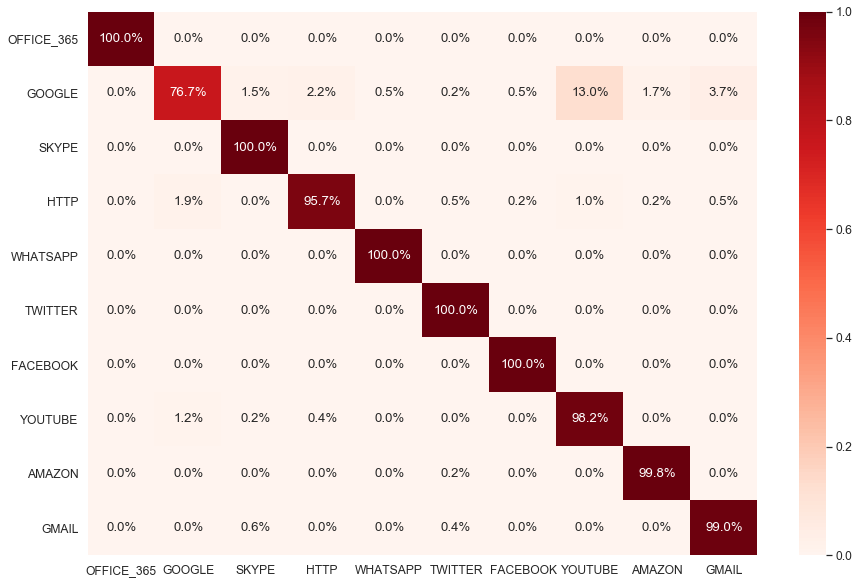

In [60]:
plt.figure(figsize=(15,10))
df_cm=pd.DataFrame(cm,columns=y_test1[y_test1.isin(apps)].unique(),index=y_test1[y_test1.isin(apps)].unique())
sns.set(font_scale=1.1)
sns.heatmap(cm_pc, annot=True,fmt='.1%',cmap=sns.color_palette("Reds",150)) # font size
plt.show()

# 6. ML methods
#### Performing ML methods on Transformed data

In [26]:
# import sklearn libraries
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# RandomForest


In [37]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(random_state=0, max_depth = 60)
clf.fit(XL_train1,yL_train2)

RandomForestClassifier(max_depth=60, random_state=0)

In [45]:
print(clf.score(XL_train1,yL_train2))# train accuracy
print(clf.score(XL_test1,yL_test2))# test accuracy

0.9415030324429859
0.9007844645675832


In [30]:
y_pred=clf.predict(XL_test1)

In [47]:
# Results
print('weighted F1 Score : ' + str(f1_score(y_pred,yL_test2,average='weighted')))
print('weighted Precision : ' + str(precision_score(y_pred,yL_test2,average='weighted')))
print('weighted Recall : ' + str(recall_score(y_pred,yL_test2,average='weighted')))

weighted F1 Score : 0.8945228929535777
weighted Precision : 0.9180610288207022
weighted Recall : 0.9007844645675832


In [48]:
# Results
print('macro F1 Score : ' + str(f1_score(y_pred,yL_test2,average='macro')))
print('macro Precision : ' + str(precision_score(y_pred,yL_test2,average='macro')))
print('macro Recall : ' + str(recall_score(y_pred,yL_test2,average='macro')))

macro F1 Score : 0.8811202439535777
macro Precision : 0.9091948576626351
macro Recall : 0.8968722819883678


# SVM

In [26]:
from sklearn.svm import SVC
clf=SVC(random_state=0,kernel='rbf').fit(XL_train1,yL_train2)

In [27]:
print(clf.score(XL_train1,yL_train2))# train accuracy
print(clf.score(XL_test1,yL_test2))# test accuracy

0.5646471316412579
0.5619350918002824


In [29]:
y_pred=clf.predict(XL_test1)

In [30]:
#results
print('weighted F1 Score : ' + str(f1_score(y_pred,yL_test2,average = 'weighted')))
print('weighted Precision : ' + str(precision_score(y_pred,yL_test2,average = 'weighted')))
print('weighted Recall : ' + str(recall_score(y_pred,yL_test2,average = 'weighted')))

weighted F1 Score : 0.5716087672478307
weighted Precision : 0.6389943732560074
weighted Recall : 0.5619350918002824


In [32]:
#results
print('macro F1 Score : ' + str(f1_score(y_pred,yL_test2,average = 'macro')))
print('macro' Precision :  + str(precision_score(y_pred,yL_test2,average = 'macro')))
print('macro Recall : ' + str(recall_score(y_pred,yL_test2,average = 'macro')))

macro F1 Score : 0.5711357632472212
macro Precision : 0.6365976626350074
macro Recall : 0.5509540914002559


# Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier(max_depth=60).fit(XL_train1,yL_train2)

In [50]:
clf.score(XL_train1,yL_train2) #train accuracy

0.9990030324429859

In [52]:
print(clf.score(XL_test1,yL_test2))# test accuracy

0.8889428844396444


In [53]:
#results
y_pred=clf.predict(XL_test1)
print('weighted F1 Score : ' + str(f1_score(y_pred,yL_test2,average = 'weighted')))
print('weighted Precision : ' + str(precision_score(y_pred,yL_test2,average = 'weighted')))
print('weighted Recall : ' + str(recall_score(y_pred,yL_test2,average = 'weighted')))

weighted F1 Score : 0.8842415669269293
weighted Precision : 0.9093726370501222
weighted Recall : 0.8889428844396444


In [34]:
#results
y_pred=clf.predict(XL_test1)
print('macro F1 Score : ' + str(f1_score(y_pred,yL_test2,average = 'macro')))
print('macro Precision : ' + str(precision_score(y_pred,yL_test2,average = 'macro')))
print('macro Recall : ' + str(recall_score(y_pred,yL_test2,average = 'macro')))

macro F1 Score : 0.874241564456929
macro Precision : 0.900267837461521
macro Recall : 0.890280052745829


### XGBOOST

In [60]:
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

In [61]:
train0=time.time()
clf = OneVsRestClassifier(XGBClassifier(verbosity=0)).fit(XL_train1, yL_train2)
train1=time.time()

In [66]:
print('Train-score: '+str(clf.score(XL_train1,yL_train2)))# train accuracy

Train-score: 0.9510555161573488


In [64]:
print('Test-score: '+str(clf.score(XL_test1,yL_test2)))# test accuracy

Test-score: 0.9170889756583867


In [37]:
#results
y_pred=clf.predict(XL_test1)
print('weighted F1 Score : ' + str(f1_score(y_pred,yL_test2,average = 'weighted')))
print('weighted Precision : ' + str(precision_score(y_pred,yL_test2,average = 'weighted')))
print('weighted Recall : ' + str(recall_score(y_pred,yL_test2,average = 'weighted')))

weighted F1 Score : 0.9205838415826192
weighted Precision : 0.9308747161575589
weighted Recall : 0.9170889756583867


In [36]:
#results
y_pred=clf.predict(XL_test1)
print('macro F1 Score : ' + str(f1_score(y_pred,yL_test2,average = 'macro')))
print('macro Precision : ' + str(precision_score(y_pred,yL_test2,average = 'maco')))
print('macro Recall : ' + str(recall_score(y_pred,yL_test2,average = 'macro')))

macro F1 Score : 0.922183877802733
macro Precision : 0.9300789263578801
macro Recall : 0.9111034044027819
